# День третий - обучение без учителя*
\* и некоторые другие темы

В сегодняшнем дне нас ждут следующие темы:
1. Немного про отбор признаков и про поиск гиперпараметров,
2. Задача понижения размерности данных,
3. Кластеризация,
4. Поиск аномалий в данных,
5. Одномерные временные ряды с помощью библиотеки `Facebook Prophet`,
6. Что такое стэкинг и как предсказания моделей использовать как вход для других моделей.

## 3.1 Отбор признаков и поиск гиперпараметров

В прошлом дне мы видили, что есть хорошие и не очень хорошие признаки, которые дают прирост качеству модели, или наоборот её ухудшают. Так же мы наивно выставляли какие-то числа в модель - количество соседей, количество нейронов в слоях... то, что называется *гиперпараметрами модели*, при этом делали это несколько от потолка.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

# загрузим наш датасет ракушек
data = pd.read_csv('data/abalone.csv')
data.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [2]:
from sklearn.utils import shuffle

# преобразуем наш категориальный признак

dataset = pd.get_dummies(data.sex).join(data).drop('sex', axis='columns')
dataset = shuffle(dataset, random_state=1)

features = list(dataset.columns)
target = 'rings'
features.remove(target)

features

['F',
 'I',
 'M',
 'length',
 'diameter',
 'height',
 'whole weight',
 'shucked weight',
 'viscera weight',
 'shell weight']

### Отбор признаков
Мы рассмотрим два метода - отбор с помощью взаимной информации между признаками, и отбор с помощью моделей. Начнем с взаимной информации. Строгое определение по сложившейся традиции тут приведено не будет, важно знать, что это *неотрицательное число*, равное 0 тогда и только когда, когда связи между признаками нет никакой. В свою очередь, чем оно больше - тем выше связь.

In [3]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, SelectKBest

train = int(len(data) * 0.8)

classification_best_features = SelectKBest(mutual_info_classif, k=4).fit(
    dataset[features][:train], dataset[target][:train]
).get_support(indices=True) # этот метод возращает номера колонок

print(
    "Если кольца считать как классификацию, лучшие 4 признака это", 
    np.array(features)[classification_best_features]
)

regression_best_features = SelectKBest(mutual_info_regression, k=4).fit(
    dataset[features][:train], dataset[target][:train]
).get_support(indices=True) # этот метод возращает номера колонок

print(
    "Если кольца считать как регрессию, лучшие 4 признака это", 
    np.array(features)[regression_best_features]
)

Если кольца считать как классификацию, лучшие 4 признака это ['diameter' 'height' 'whole weight' 'shell weight']
Если кольца считать как регрессию, лучшие 4 признака это ['diameter' 'height' 'whole weight' 'shell weight']


Что ж, посчитаем регрессию и классификацию на этих четырех признаках.

In [4]:
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.neural_network import MLPRegressor, MLPClassifier

classifier = MLPClassifier(random_state=1, max_iter=1000).fit(
    dataset.values[:, classification_best_features][:train],
    dataset[target][:train]
)
regressor = MLPRegressor(random_state=1, max_iter=1000).fit(
    dataset.values[:, regression_best_features][:train],
    dataset[target][:train]
)

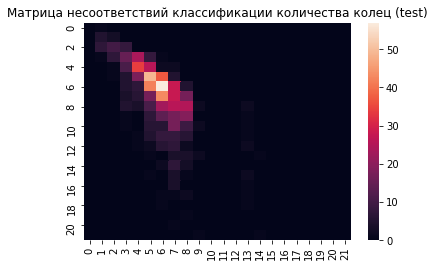

In [5]:
import matplotlib.pyplot as plt

plt.title("Матрица несоответствий классификации количества колец (test)");
sns.heatmap(confusion_matrix(
    dataset[target][train:],
    classifier.predict(dataset.values[:, classification_best_features][train:])
));

In [6]:
print("R2 test regression %.3f, classification (trick) %.3f" % (
    r2_score(dataset[target][train:], regressor.predict(dataset.values[:, regression_best_features][train:])),
    r2_score(dataset[target][train:], classifier.predict(dataset.values[:, classification_best_features][train:]))
))

R2 test regression 0.476, classification (trick) 0.278


Вот так можно отбирать признаки в задачах регрессии и классификации с помощью взаимной информации. Но можно делать это еще интересней - с помощью других моделей!

> Для моделей часто важна интерпретируемость! Мы об это будем обязательно говорить. Линейные модели и деревья - интерпретируемы, нейросети с трудом или практически нет.

**Интерпретируемость** означает, что мы можем понять, что даёт наибольший вклад в предсказания. Она может быть локальной - в одном примере, а может быть глобальной - для всей модели. Так, деревья имеют после подгонки определенные коэффициенты важности, они же `tree_estimator.feature_importances_`, которые показывают, какой признак даёт наибольший вклад в предсказание. С линейными моделями - еще проще, там коэффициенты при признаках указывают на вклад (но учитывайте единицы измерения!).

In [7]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

selector_linear = SelectFromModel(estimator=LinearRegression()).fit(
    dataset[features][:train], dataset[target][:train]
)

selector_forest = SelectFromModel(estimator=RandomForestRegressor(n_estimators=100, random_state=1)).fit(
    dataset[features][:train], dataset[target][:train]
)

linear_features = np.array(features)[selector_linear.get_support()]
forest_features = np.array(features)[selector_forest.get_support()]

print("По линейной модели", linear_features)
print("По случайному лесу", forest_features)

По линейной модели ['F' 'I' 'M']
По случайному лесу ['shucked weight' 'shell weight']


In [8]:
print("R2 по линейным признакам %.3f (test set)" % (
    r2_score(
        dataset[target][train:],
        MLPRegressor(random_state=1, max_iter=1000).fit(
            dataset[linear_features][:train], dataset[target][:train]
        ).predict(
            dataset[linear_features][train:]
        )
    )
))

print("R2 по признакам случайного леса %.3f (test set)" % (
    r2_score(
        dataset[target][train:],
        MLPRegressor(random_state=1, max_iter=1000).fit(
            dataset[forest_features][:train], dataset[target][:train]
        ).predict(
            dataset[forest_features][train:]
        )
    )
))

R2 по линейным признакам 0.201 (test set)
R2 по признакам случайного леса 0.537 (test set)


Как видим, линейные модели сильно проиграли случайному лесу в отборе признаков на текущих данных.

Заметим, мы использовали значения по умолчанию для `MLPRegressor`, хорошо ли это? Мы не знаем. Для того, чтобы попробовать сразу много вариантов, да еще и с кросс-валидацией, можно использовать встроенный в `scikit-learn` класс `GridSearchCV`, который осуществляет *перебор по сетке гиперпараметров*.

Можно показать как это работает на примере.

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# перебор всех сочетаний параметров
# это может занимать много времени!

search = GridSearchCV(
    KNeighborsRegressor(),
    param_grid = {
        'n_neighbors': [3, 5, 7, 10, 25],
        'weights': ['uniform', 'distance']
    },
    cv=5
).fit(
    dataset[features], dataset[target]
)

'лучший отобранный по кросс-валидации', search.best_estimator_, \
'наилучшее значение метрики (R2) %.3f' % search.best_score_

('лучший отобранный по кросс-валидации',
 KNeighborsRegressor(n_neighbors=25, weights='distance'),
 'наилучшее значение метрики (R2) 0.540')

Как видим, ближайшие соседи могут даже сравниться с нейросетями.

> Имейте в виду! Когда мы отобрали по кросс-валидации лучшие гиперпараметры, перед отправкой модели в *среду эксплуатации* (для работы сайта например), мы можем её обучить с найденными параметрами уже на всех данных. Хуже от этого она предсказывать не будет - если вы, конечно, почистили данные от выбросов.


### В качестве заключения
Не стоит в любом случае сильно увлекаться автоматическими отборами и переборами - разведочный анализ пропускать нельзя. Но если признаков не 5 и не 10, эти методы могут сослужить хорошую службу. Их даже можно объединять в так называемые `pipelines`, то есть соединять последовательно. Если интересно, про них более подробно [можно найти в разделе документации "combining estimators" библиотеки scikit-learn](https://scikit-learn.org/stable/modules/compose.html#combining-estimators).

## 3.2 Понижение размерности

Задача понижения размерности - это задача обучения без учителя, то есть когда у нас **нет правильных ответов**. Решение задач без разметки ответов часто используется для анализа и предобработки, например для отображения сложных данных.

Понижение размерности - это сжатие признаков датасета до более меньшего числа, при попытке не потерять информацию в нём и её полезные свойства. 

### Principal component analysis (PCA)

`PCA` - это линейное преобразование (то есть `y1 = k11 * x1 + ... + b1`) всех признаков данных, с целью оставить в них как больше информации - а точнее, оставить как можно больше разброса в величинах. Главная компонента - это направление в данных, в котором разброс (вариабельность) этих самых данных наибольшая (и далее берется следующее направление). Направлений столько, сколько признаков в данных.

> **ВАЖНО**: поскольку `PCA` работает с разбросом, все величины надо стандартизировать (вычесть среднее и разделить на разброс), чтобы привести к единой шкале!

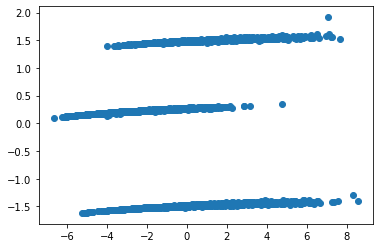

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

# отобразим все признаки кроме колец на плоскость
PCA = make_pipeline(
    StandardScaler(), PCA(n_components=2)
)

transformed = PCA.fit_transform(dataset[features])

plt.scatter(transformed[:, 0], transformed[:, 1]);

Вот как-то так. Являются ли полученные полосы разделением по полам?

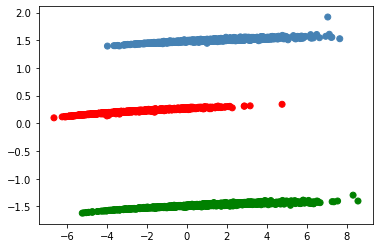

In [11]:
colors = []

for sample in dataset.values:
    if sample[0] == 1:
        colors.append('steelblue')
    elif sample[1] == 1:
        colors.append('red')
    else:
        colors.append('green')

plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Какой из этого можно сделать вывод? Что данные хорошо разделяются по полам? Нет, не такой вывод, но то, что пол - это одно из важнейших различий в данных. И, возможно, имеет смысл делать три модели для каждого пола.

Существует достаточно сложный метод `UMAP`, который всегда укладывает только на плоскость все данные, обычно для целей визуализации. Не так сейчас важно как он работает в теории (в теории он ищет меньший граф связей, похожий на полученный из данных), сколько важно посмотреть как он отработает на наших данных.

Суть в том, что он делает это нелинейно.

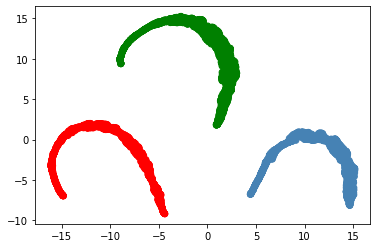

In [12]:
# запретим предупреждения
import warnings
warnings.filterwarnings('ignore')

from umap import UMAP

# поступим аналогично, но уже без всяких предобработок

transformed = UMAP().fit_transform(dataset[features])
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Ничего не напоминает? :) Это, конечно, замечательно, но интересует, разделяются ли данные по полам, если эти признаки пола убрать?

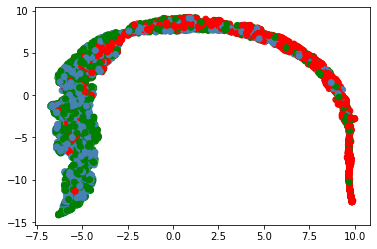

In [13]:
transformed = UMAP().fit_transform(dataset[features[3:]])
plt.scatter(transformed[:, 0], transformed[:, 1], c=colors);

Как видим, не очень хорошо, и пол - это очень важный признак. Если бы мы хотели по остальным признакам различать пол, у нас бы это плохо получалось.

### Заключение
Методы понижения размерности могут и в основном используются для двух целей:
1. Цели визуализации сложных данных,
2. Цели сокращения размерности задачи, то есть уменьшения количества входных признаков.

**Учтите!** Когда вы используете методы понижения размерности и собираетесь результат передавать в модель, *делайте для них **подгонку только на тренировочном** множестве*!

## 3.3 Кластеризация

Кластеризация - задача обучения без учителя, в которой каждому примеру надо сопоставить номер группы (кластера) таким образом, чтобы схожие примеры были в одном кластере. Что значит схожие? Это означает близкие по некоторому расстоянию.

Расстояние:
- может быть евклидовым: `distance(a, b) = sqrt((a1 - b1)**2 + ... (ak - bk)**2)`,
- косинусным: `distance(a, b) = 1 - косинус угла между векторами (a, b) = 1 - (a1*b1 + ... ak*bk) / sqrt(a1**2 + ... ak**2) / sqrt(b1**2 + ... bk**2)`,
- манхэтэннским (по координатным прямым между точками): `distance (a, b) = |a1 - b1| + ... |ak - bk|`,
- есть и другие расстояния.

Но как можно найти кластеры в данных? Давайте рассмотрим алгоритм, который разбивает точки на заранее заданное число кластеров.
1. На первом шаге мы инициализируем случайные центроиды кластеров (случайные точки),
2. Посчитаем расстояния между каждой точкой и центроидами,
3. Присвоим номера кластеров точкам по ближайшему расстоянию до конкретного центроида,
4. Пересчитаем центроиды как центры полученных кластеров,
5. Повторим шаги 2-4, пока центроиды не перестанут меняться.

In [14]:
from sklearn.datasets import load_iris

# заберем только признаки, и только последние два, перемешаем
X = shuffle(load_iris(return_X_y=True)[0][:, -2:], random_state=1)

def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def clustering(number_clusters, X):
    np.random.seed(1)
    
    # первый шаг - случайная инициализация
    centroids = np.array([
        [
            np.random.uniform(X[:, 0].min(), X[:, 0].max()),
            np.random.uniform(X[:, 1].min(), X[:, 1].max())
        ] for _ in range(number_clusters)
    ]).reshape(number_clusters, 2)
    
    previous = np.zeros_like(centroids)
    clusters = None
    
    iteration = 0
    while not np.allclose(previous, centroids):
        previous = centroids.copy()
    
        # шаг 2, считаем все расстояния
        distances = []
        for centroid in centroids:
            distances.append([
                distance(X[index], centroid) \
                for index in range(len(X))
            ])
        
        distances = np.array(distances).reshape(
            number_clusters, len(X)
        )
        
        # шаг3, присваеваем метки точкам
        clusters = []
        for index in range(len(X)):
            clusters.append(
                np.argmin(distances[:, index])
            )
        clusters = np.array(clusters).reshape(len(X))
        
        # шаг 4, пересчитываем центроиды
        centroids = []
        for index in range(number_clusters):
            centroids.append([
                X[np.where(clusters == index), 0].mean(),
                X[np.where(clusters == index), 1].mean(),
            ])
        centroids = np.array(centroids).reshape(number_clusters, 2)
        
        iteration += 1
        print("%d, изменение расстояния центроидов %.4f" % (
            iteration, distance(previous, centroids)
        ))
    
    return centroids, clusters
            
centroids, clusters = clustering(3, X)

1, изменение расстояния центроидов 1.6271
2, изменение расстояния центроидов 0.1064
3, изменение расстояния центроидов 0.1023
4, изменение расстояния центроидов 0.0460
5, изменение расстояния центроидов 0.0828
6, изменение расстояния центроидов 0.1951
7, изменение расстояния центроидов 0.2680
8, изменение расстояния центроидов 0.8304
9, изменение расстояния центроидов 0.7299
10, изменение расстояния центроидов 0.3966
11, изменение расстояния центроидов 0.2829
12, изменение расстояния центроидов 0.1459
13, изменение расстояния центроидов 0.0431
14, изменение расстояния центроидов 0.0648
15, изменение расстояния центроидов 0.0220
16, изменение расстояния центроидов 0.0000


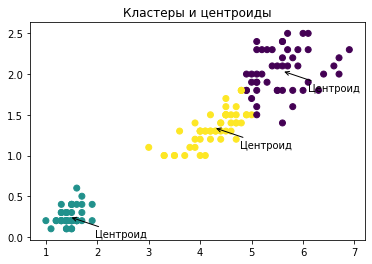

In [15]:
plt.title("Кластеры и центроиды");
plt.scatter(X[:, 0], X[:, 1], c=clusters);
for index, centroid in enumerate(centroids):
    plt.annotate(
        "Центроид",
        (centroid[0], centroid[1]),
        (centroid[0] + 0.5, centroid[1] - 0.25),
        arrowprops={"arrowstyle": '->'}
    );

Всё то же самое, только лучше, умеет делать класс `KMeans` из библиотеки `scikit-learn`. Посмотрим как он работает, но сперва узнаем, что для кластеризации тоже существуют метрики качества, и одна из самых интересных - это *метрика силуэта*, `silhouette_score`.

Метрика силуэта меняется от -1 (худший случай) до +1 (лучший), и показывает, насколько "хорошо" принадлежат точка своему кластеру (для всех данных - значение усредняется). Хорошо принадлежит, это значит расстояние до ближайшего кластера, отличного от кластера точки, больше расстояния до кластера самой точки. Или, еще проще, точка находится среди таких же.

Поэтому в случае, когда мы не знаем количество кластеров заранее, мы можем перебирать и сравнивать их по метрике силуэта.

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_score = -1
best_number = 0

whole_X = shuffle(
    load_iris(return_X_y=True)[0],
    random_state=1
)

# переберем от 22 кластеров до 2
for number_clusters in range(22, 1, -1):
    clusterer = KMeans(n_clusters=number_clusters, random_state=1).fit(whole_X)
    score = silhouette_score(whole_X, clusterer.labels_)
    
    if score > best_score:
        best_score = score
        best_number = number_clusters
        print("%d: улучшение, метрика силуэта %.3f" % (number_clusters, score))

22: улучшение, метрика силуэта 0.278
18: улучшение, метрика силуэта 0.289
15: улучшение, метрика силуэта 0.295
14: улучшение, метрика силуэта 0.309
11: улучшение, метрика силуэта 0.317
10: улучшение, метрика силуэта 0.325
9: улучшение, метрика силуэта 0.341
8: улучшение, метрика силуэта 0.350
7: улучшение, метрика силуэта 0.359
6: улучшение, метрика силуэта 0.365
5: улучшение, метрика силуэта 0.489
4: улучшение, метрика силуэта 0.498
3: улучшение, метрика силуэта 0.553
2: улучшение, метрика силуэта 0.681


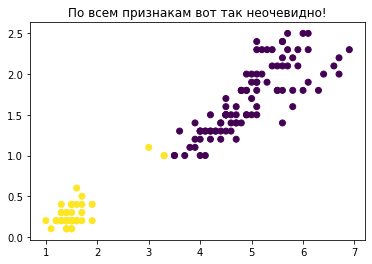

In [17]:
plt.title("По всем признакам вот так неочевидно!");
clusterer = KMeans(n_clusters=best_number, random_state=1).fit(whole_X)
plt.scatter(X[:, 0], X[:, 1], c=clusterer.labels_);

Внезапно оказалось, что два кластера - это лучшее разбиение точек на группы с точки зрения метрики силуэта! То есть делить цветы на три сорта не факт что правильно, так как две группы очень схожи.

Есть методы, которые заранее не требуют задавать количество кластеров, и мы такой рассмотрим, он называется `DBSCAN`. Он, в свою очередь, требует как минимум задать размер шара, попадая в который соседние для выбранной точки считаются попадающими в одну группу.

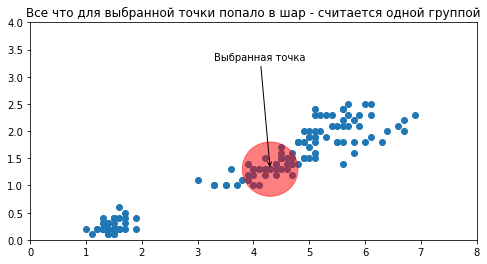

In [18]:
plt.figure(figsize=(8, 4));

plt.title("Все что для выбранной точки попало в шар - считается одной группой");
plt.gcf().gca().add_artist(plt.Circle(X[len(X) // 2], 0.5, color='red', alpha=0.5));
plt.scatter(X[:, 0], X[:, 1]);

plt.annotate(
    "Выбранная точка",
    X[len(X) // 2],
    (X[len(X) // 2, 0] - 1, X[len(X) // 2, 1] + 2),
    arrowprops={"arrowstyle": '->'}
)

plt.xlim(0, 8);
plt.ylim(0, 4);

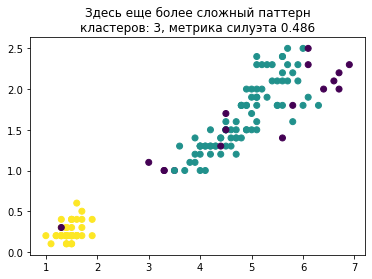

In [19]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5).fit(whole_X)
plt.title("Здесь еще более сложный паттерн\nкластеров: %d, метрика силуэта %.3f" % (
    len(pd.unique(dbscan.labels_)), silhouette_score(whole_X, dbscan.labels_)
));
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_);

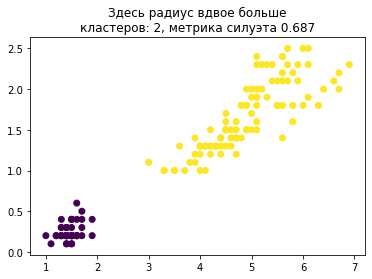

In [20]:
dbscan = DBSCAN(eps=1).fit(whole_X)
plt.title("Здесь радиус вдвое больше\nкластеров: %d, метрика силуэта %.3f" % (
    len(pd.unique(dbscan.labels_)), silhouette_score(whole_X, dbscan.labels_)
));
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_);

### В качестве заключения

Что может кластеризация? **Разбить на группы? Не только это**. После разбиения на группы с помощью анализа признаков можно добиться очень содержательных выводов. Так, рассмотрев более пристально что попадает в каждую группу (какие значения признаков), можно узнать о процессе гораздо больше, чем просто глядя на сырые данные. И получить ответы на поставленные вопросы.